# Contact analysis: write your own contacts analysis method

The `contacts.Contacts` class has been designed to be extensible for your own analysis. Here we demonstrate how to define a new method to use to determine the fraction of native contacts.

**Last updated:** January 2020

**Minimum version of MDAnalysis:** 0.20.1

**Packages required:**
    
* MDAnalysis [[1, 2]](#References)
* MDAnalysisTests
   
**Optional packages for molecular and data visualisation:**
    
* [matplotlib](https://matplotlib.org)
* [pandas](https://pandas.pydata.org)

In [7]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis import contacts

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. [[3]](#References) The trajectory ``DCD`` samples a transition from a closed to an open conformation.

In [8]:
u = mda.Universe(PSF, DCD)

## Defining salt bridges

We define salt bridges as contacts between NH/NZ in ARG/LYS and OE\*/OD\* in ASP/GLU. You may not want to use this definition for real work.

In [9]:
sel_basic = "(resname ARG LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP GLU) and (name OE* OD*)"
acidic = u.select_atoms(sel_acidic)
basic = u.select_atoms(sel_basic)

## Define your own function

Any function you define *must* have `r` and `r0` as its first and second arguments respectively, even if you don't necessarily use them:

   - `r`: an array of distances between atoms at the current time
   - `r0`: an array of distances between atoms in the reference

You can then define following arguments as keyword arguments.

In the function below, we calculate the fraction of native contacts that are less than `radius`, but greater than `min_radius`.

In [12]:
def fraction_contacts_between(r, r0, radius=3.4, min_radius=2.5):
    is_in_contact = (r < radius) & (r > min_radius)  # array of bools
    fraction = is_in_contact.sum()/r.size
    return fraction

Then we pass `fraction_contacts_between` to the `contacts.Contacts` class. Keyword arguments for our custom function must be in the `kwargs` dictionary. Even though we define a `radius` keyword in my custom analysis function, it is *not* automatically passed from `contacts.Contacts`. We have to make sure that it is in `kwargs`. 

In [13]:
ca = contacts.Contacts(u, 
                       selection=(sel_acidic, sel_basic),
                       refgroup=(acidic, basic),
                       method=fraction_contacts_between,
                       radius=5.0,
                       kwargs={'radius': 5.0,
                               'min_radius': 2.4}).run()

In [14]:
ca_df = pd.DataFrame(ca.timeseries, 
                    columns=['Frame', 
                             'Contacts from first frame'])

### Plotting

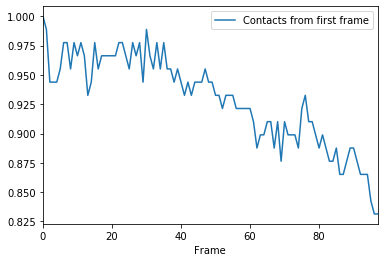

In [15]:
ca_df.plot(x='Frame')

## References

[1]: R. J. Gowers, M. Linke, J. Barnoud, T. J. E. Reddy, M. N. Melo, S. L. Seyler, D. L. Dotson, J. Domanski, S. Buchoux, I. M. Kenney, and O. Beckstein. [MDAnalysis: A Python package for the rapid analysis of molecular dynamics simulations](http://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html). In S. Benthall and S. Rostrup, editors, *Proceedings of the 15th Python in Science Conference*, pages 98-105, Austin, TX, 2016. SciPy, [doi:10.25080/majora-629e541a-00e](https://doi.org/10.25080/majora-629e541a-00e).

[2]: N. Michaud-Agrawal, E. J. Denning, T. B. Woolf, and O. Beckstein. MDAnalysis: A Toolkit for the Analysis of Molecular Dynamics Simulations. *J. Comput. Chem*. 32 (2011), 2319-2327, doi:[10.1002/jcc.21787](https://dx.doi.org/10.1002/jcc.21787). PMCID:[PMC3144279](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144279/)

[3]: O. Beckstein, E.J. Denning, J.R. Perilla, T.B. Woolf. Zipping and unzipping of adenylate kinase: atomistic insights into the ensemble of open<-->closed transitions. *J Mol Biol*. 2009;394(1):160–176. [doi:10.1016/j.jmb.2009.09.009](https://dx.doi.org/10.1016%2Fj.jmb.2009.09.009)